# 一切都是套路

In [1]:
#!/usr/bin/env python
#coding=utf-8
import sys
from IPython.display import Image


import os,sys
import numpy as np
import random
import codecs
import torch as t
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable


is_cuda = t.cuda.is_available()

In [2]:
import re
html_tag= re.compile(r'<[^>]+>')
def remove_tags(text):
    return html_tag.sub('', text)

In [3]:
corpus=[]
with codecs.open('news1.txt', 'r', 'utf-8') as f:
    corpus = list(''.join(f.readlines()))
print('total chars:{0}'.format(len(corpus)))

total chars:1419584


In [4]:
n_seqs, n_steps = 64, 32
vocabs = sorted(list(set(''.join(corpus))))
print('vocabs:{}'.format(len(vocabs)))
idx2char= {i: w for i, w in enumerate(vocabs)}
char2idx = {w: i for i, w in enumerate(vocabs)}


vocabs:3545


In [5]:
curr_idx = 0
text=corpus[curr_idx:curr_idx+n_seqs* n_steps*100]

encoded = np.array([char2idx[ch] for ch in text])
def one_hot_encode(arr, n_labels):
    one_hot = np.zeros((np.multiply(*arr.shape), n_labels), dtype=np.float32)
    one_hot[np.arange(one_hot.shape[0]), arr.flatten()] = 1.
    one_hot = one_hot.reshape((*arr.shape, n_labels))
    return one_hot


def get_batches(arr, n_seqs, n_steps):
    '''Create a generator that returns mini-batches of size
       n_seqs x n_steps from arr.
    '''
    batch_size = n_seqs * n_steps
    n_batches = len(arr)//batch_size
    
    # Keep only enough characters to make full batches
    arr = arr[:n_batches * batch_size]
    # Reshape into n_seqs rows
    arr = arr.reshape((n_seqs, -1))
    
    for n in range(0, arr.shape[1], n_steps):
        # The features
        x = arr[:, n:n+n_steps]
        # The targets, shifted by one
        y = np.zeros_like(x)
        try:
            y[:, :-1], y[:, -1] = x[:, 1:], arr[:, n+n_steps]
        except IndexError:
            y[:, :-1], y[:, -1] = x[:, 1:], arr[:, 0]
        yield x, y
        


## Focal Loss 让深度学习不再柿子挑软的吃

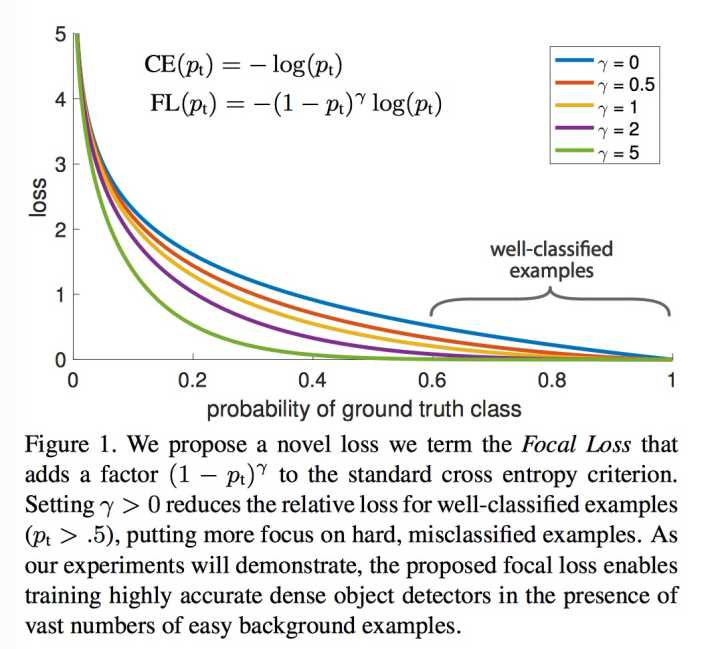

In [6]:
Image(filename='focalloss.jpg')

In [7]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=0, alpha=None, size_average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        if isinstance(alpha,(float)): self.alpha = t.Tensor([alpha,1-alpha])
        if isinstance(alpha,list): self.alpha = t.Tensor(alpha)
        self.size_average = size_average

    def forward(self, input, target):
        if input.dim()>2:
            input = input.view(input.size(0),input.size(1),-1)  # N,C,H,W => N,C,H*W
            input = input.transpose(1,2)    # N,C,H*W => N,H*W,C
            input = input.contiguous().view(-1,input.size(2))   # N,H*W,C => N*H*W,C
        target = target.view(-1,1)

        logpt = F.log_softmax(input, dim=1)
        logpt = logpt.gather(1,target)
        logpt = logpt.view(-1)
        pt = Variable(logpt.data.exp())

        if self.alpha is not None:
            if self.alpha.type()!=input.data.type():
                self.alpha = self.alpha.type_as(input.data)
            at = self.alpha.gather(0,target.data.view(-1))
            logpt = logpt * Variable(at)

        loss = -1 * (1-pt)**self.gamma * logpt
        if self.size_average: return loss.mean()
        else: return loss.sum()

## Pull-away term Loss   让深度学习从此喜欢多变

In [8]:
def pullaway_loss(embeddings):
    norm = t.sqrt(t.sum(embeddings ** 2.0, 1, keepdim=True))
    normalized_embeddings = embeddings / norm
    similarity = t.matmul(normalized_embeddings, normalized_embeddings.transpose(1, 0))
    batch_size = embeddings.size()[0]
    pt_loss = (t.sum(similarity) - batch_size) / (batch_size * (batch_size - 1))
    return pt_loss




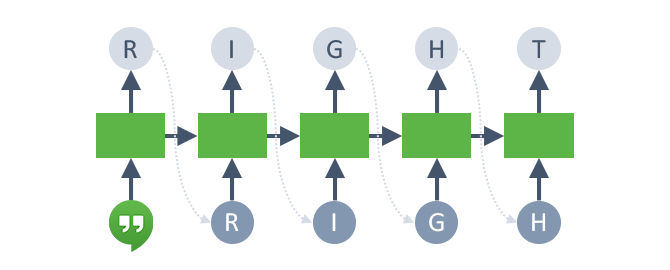

In [9]:
Image(filename='charrnn.png')

In [10]:
class CharRNN(nn.Module):
    def __init__(self, vocabs, n_steps=100, n_hidden=256, n_layers=2,
                               drop_prob=0.5, lr=0.001):
        super().__init__()
        self.drop_prob = drop_prob
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.lr = lr
        
        self.vocabs = vocabs
        self.idx2char = dict(enumerate(self.vocabs))
        self.char2idx = {ch: ii for ii, ch in self.idx2char.items()}
        
        self.dropout = nn.Dropout(drop_prob)
        self.lstm = nn.LSTM(len(self.vocabs), n_hidden, n_layers, 
                            dropout=drop_prob, batch_first=True)
        self.fc = nn.Linear(n_hidden, len(self.vocabs))
        
        self.init_weights()
        
    def forward(self, x, hc):
        x, (h, c) = self.lstm(x, hc)
        x = self.dropout(x)
        
        x = x.view(x.size()[0]*x.size()[1], self.n_hidden)
        
        x = self.fc(x)
        
        return x, (h, c)
    
    def predict(self, char, h=None, cuda=False, top_k=None):
        ''' 输入一个字去预测下一个字
            回传预测的字以及隐状态
        '''
        if cuda:
            self.cuda()
        else:
            self.cpu()
        
        if h is None:
            h = self.init_hidden(1)
        
        x = np.array([[self.char2idx[char]]])
        x = one_hot_encode(x, len(self.vocabs))
        inputs = Variable(t.from_numpy(x), volatile=True)
        if cuda:
            inputs = inputs.cuda()
        
        h = tuple([Variable(each.data, volatile=True) for each in h])
        out, h = self.forward(inputs, h)

        p = F.softmax(out, dim=1).data
        if cuda:
            p = p.cpu()
        
        if top_k is None:
            top_ch = np.arange(len(self.vocabs))
        else:
            p, top_ch = p.topk(top_k)
            top_ch = top_ch.numpy().squeeze()
        
        p = p.numpy().squeeze()
        char = np.random.choice(top_ch, p=p/p.sum())
            
        return self.idx2char[char], h
    
    def init_weights(self):
        ''' 初始化权重'''
        initrange = 0.1
        
        self.fc.bias.data.fill_(0)
        self.fc.weight.data.uniform_(-1, 1)
        
    def init_hidden(self, n_seqs):
        weight = next(self.parameters()).data
        return (Variable(weight.new(self.n_layers, n_seqs, self.n_hidden).zero_()),
                Variable(weight.new(self.n_layers, n_seqs, self.n_hidden).zero_()))

In [18]:
companies=['格力','科大讯飞','平安银行','神州高铁','东阿阿胶','苏宁环球','云南白药','五粮液','金螳螂','海康威视']

def write_something(net, size=200, cuda=False, prime='马云', top_k=5):
    if is_cuda:
        net.cuda()
    else:
        net.cpu()

    net.eval()

    #首先先输入提示词
    words = [ch for ch in prime]
    h = net.init_hidden(1)
    for ch in prime:
        char, h = net.predict(ch, h, cuda, top_k=top_k)

    words.append(char)

    # 在把每次結果逐一當作輸入再投入
    for ii in range(size):
        char, h = net.predict(words[-1], h, cuda, top_k=top_k)
        words.append(char)

    return ''.join(words)


In [19]:
def train(net, data, epochs=100, n_seqs=64, n_steps=32, lr=0.001, clip=5, val_frac=0.1, cuda=False, print_every=10):
    global companies
    ''' Traing a network 
    
        Arguments
        ---------
        
        net: CharRNN network
        data: text data to train the network
        epochs: Number of epochs to train
        n_seqs: Number of mini-sequences per mini-batch, aka batch size
        n_steps: Number of character steps per mini-batch
        lr: learning rate
        clip: gradient clipping
        val_frac: Fraction of data to hold out for validation
        cuda: Train with CUDA on a GPU
        print_every:每隔几次打印一回训练中间状态
    
    '''
    net.train()
    opt = t.optim.Adam(net.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    
    # create training and validation data
    val_idx = int(len(data)*(1-val_frac))
    data, val_data = data[:val_idx], data[val_idx:]
    
    if cuda:
        net.cuda()
    
    counter = 0
    n_chars = len(net.vocabs)
    for e in range(epochs):
        h = net.init_hidden(n_seqs)
        for x, y in get_batches(data, n_seqs, n_steps):
            counter += 1
            
            #  One-hot 将语料转换为pytorch张量
            x = one_hot_encode(x, n_chars)
            x, y = t.from_numpy(x), t.from_numpy(np.int64(y))
            
            inputs, targets = Variable(x), Variable(y)
            if cuda:
                inputs, targets = inputs.cuda(), targets.cuda()

            h = tuple([Variable(each.data) for each in h])

            net.zero_grad()
            
            output, h = net.forward(inputs, h)

            loss = criterion(output, targets.view(n_seqs*n_steps))+FocalLoss(gamma=2)(output, targets.view(n_seqs*n_steps))+0.1*pullaway_loss(output)
                

            loss.backward()
            
            # 透过梯度截断机制可以避免梯度爆炸.
            nn.utils.clip_grad_norm(net.parameters(), clip)

            opt.step()
            if counter % 2*print_every == 0:
                t.save(net.state_dict(),'Models/CharRnn.rnn')
            if counter % print_every == 0:
                t.save(net.state_dict(),'Models/CharRnn_{0}.rnn'.format(e))
                t.save(net.state_dict(),'Models/CharRnn.rnn')
                # Get validation loss
                val_h = net.init_hidden(n_seqs)
                val_losses = []
                for x, y in get_batches(val_data, n_seqs, n_steps):
                    # One-hot 将语料转换为pytorch张量
                    x = one_hot_encode(x, n_chars)
                    x, y = t.from_numpy(x), t.from_numpy(np.int64(y))
                    
                    # 为隐藏状态设计独立变量，以简化计算流程
                    val_h = tuple([Variable(each.data, volatile=True) for each in val_h])
                    
                    inputs, targets = Variable(x, volatile=True), Variable(y, volatile=True)
                    if cuda:
                        inputs, targets = inputs.cuda(), targets.cuda()

                    output, val_h = net.forward(inputs, val_h)
                    val_loss = criterion(output, targets.view(n_seqs*n_steps))+FocalLoss(gamma=2)(output, targets.view(n_seqs*n_steps))+0.1*pullaway_loss(output)
                
                    val_losses.append(val_loss.data[0])
                    
                #打印模型训练中间状态
                print("Epoch: {}/{}...".format(e+1, epochs),
                      "Step: {}...".format(counter),
                      "Loss: {:.4f}...".format(loss.data[0]),
                      "Val Loss: {:.4f}".format(np.mean(val_losses)))
                print(write_something(net, 500, cuda, prime=random.choice(companies), top_k=5))


In [20]:
if 'net' in locals():
    del net

In [21]:
net = CharRNN(vocabs, n_hidden=512, n_layers=2)
#若是模型已经存在则还原
if os.path.exists('Models/CharRnn.rnn'):
    net.load_state_dict(t.load('Models/CharRnn.rnn'))
    print('模型已经加载复原')

In [22]:
n_seqs, n_steps = 32, 64
n_batches=100

 #只是单纯先设定一个够大可以容纳下训练数据，但又不会大到把内存用尽的大小
train(net, encoded, epochs=25, n_seqs=n_seqs, n_steps=n_steps, lr=0.001, cuda=True, print_every=10)

Epoch: 1/25... Step: 10... Loss: 13.2031... Val Loss: 15.1951
格力5511000550,25020,2,51102,110205,,2,120,115,55,,2,5,,5,100200200055515,02,02,52,20,01,0210050,0102000210,,2000052520100,10210520151102,202002,0,0001,250,,,05000001552,,01,2,05000,,00,5000101,00,2111,225,2,500225,1020,5,,15,52,2110202,,,02,51,,0202,112001522501500210,000052250,00200505,0000051201,0,20110050022,2520,00211520102,,05000015000021,512,2250,5000202120,1,,501210115021,150,01,0010110211502200221022000010100050,050,5055,1520,02,0550,11022,002100,50050050100020,000,0,0,000,,11,022,2,,10050,0
Epoch: 1/25... Step: 20... Loss: 11.5504... Val Loss: 13.8045
神州高铁00133100100113101010,310010101100150339,,15000,0503,5,,,00,591,00031,,393,0,0910,01,0003,931,10,,11,150190,15000050105,031,0,,0130,99,0000,10011,0011,,1150,,00,9,100151,3,0130051,,30,1,,,1,,10,0000033,1,011,390,3,1,31,,1,11031,339,0,10,,,901033,03110000,3,10103,,0,1,51,0000001,0000000100,3010100,,,3,01011,300000,0050,00,5001,1000,000000,01105,1,11,0,050,,1530030,1,0

Epoch: 2/25... Step: 160... Loss: 8.0447... Val Loss: 11.5597
科大讯飞，410.5023.40001.50000040600038690901984330030699699899,98600220100340000000669099919,899,606,902020,402,5001,40260,54320115,000000215S)华900005000000060500600150000000256400066004039020055,300010054498331,6601,5012,202015,0496,291,42201,95021540002154900026004093600055909392,580012,40000214400600265中华证券1,562,68122,2021,500000000000099660065,50052,04201,40003,40000026600160999880900059590690065544036,70005100004035400105946016,791,90020,6469,021,00500000000096799801050006569960052,70111,662,66,026,
Epoch: 2/25... Step: 170... Loss: 8.1351... Val Loss: 11.3764
东阿阿胶015,436014015.0360100014000636,159,944003,030000000000030000504500420010054030003,594303,3413,0200000015340030002514433602,504,1514,30015,303300,454,39300,155,46030,203,444,0000,2540044003390100534000000003600015,5000015100406000301450030,3300051,30011,500010,3060,0300,502000000003000010354000001516436010,000215040001535040010545,90001,5030104540003301030036115003

Epoch: 4/25... Step: 310... Loss: 6.5637... Val Loss: 10.5122
云南白药、000400点。其中长16-4.65亿元，同比增长1.4%；其中，实现净利润76.66亿元，其中金融资余额16.88亿元，比上升15.56%。1104年，同比增长1.6%，但同比上降.8%。目前前，银行业绩预增幅度低于2.6%的股份。银行中国有银行高管理财产品结构、国家银行业务部、中国银行合作经营主营业务，同比增长3.00%。目前已经济中行业绩的一季度业务收购，同增长750%，公司收购13.46万元。1400040101004504616680145040066501641160001514.65100000164015104043354411403600185000360140300000460040211004016004031040360004601100401040315140360003540400150441500001550006500043020150403265043600000000040022520154406015035040030045040650015040600021504063601514032021554436060111140161510001660
Epoch: 4/25... Step: 320... Loss: 6.1341... Val Loss: 10.5002
格力。2014年公司2015年2.13万股权1.20%1150.3600169.SZ中国际建4.310033000018中华泰银114.93%201001603.6160.5140.360000038中华泰份134.566.913.1100.366.02220400036036878中国平安804016,609193,0903900036中国南平91,396,94319,009,0090,900010150403610150天股份153,991,849133,091,03960,9569,800000401036036114天津科技43016,192,9363,919,64161,131,494011,88220050406601380016000360中国际建设60020.5200069.18012360046311103601

Epoch: 6/25... Step: 460... Loss: 5.2224... Val Loss: 10.4544
金螳螂012000-0.53元；据东方财富Chordceloice数据统计显的大数据，2014年4月20000104000000500.00245840003600150华夏50228,005000150003000025东方电子200,9003,69050,253,954220,50024,15000520153401004885040050400201504026652015004250150100400108801502430030020250402203503600450150303600180403601119大华电551,992,9582411,8985,5552,48512,100400114040022815大一品012,203,2259159,800018,1581,5041,50340025140200500320201504030001104新信息2012,955,495202,580010,700022,50030150450300223华泰控制202,390,025551,5284,85185,920024,50021,5003005504003002855山新洋10
Epoch: 6/25... Step: 470... Loss: 5.1436... Val Loss: 10.4327
云南白药股份(002288)中金公司股份，(600199.SZ)长金证券买入-2.9--23日晚间，交通银行资金理财产品销售同比增长15.4%。公司2014年年报，2515年4月2.54%，增长加上海信息 3.29%，其中，国家上市公司2.15%；4月7日，公司将继续稳步推动，国北车口推动力，159.43%，上海外公司的资源分别为2.51%，同比增长23.6%；归属于上市公司股东净利润1.68亿元，同时增长 6.6%，增长期或出现有望成为，新股的时间，还是公司不足，有望这一些机会在高管，这个股指出，这是这个情况下降，不能少公司将是加速、高达、新产能、东方财富Choocee数据，沪深指指数上海高端(300153)预计算机公司将达到14 亿-1.5-%，预告期内(1114 亿)，公司预期计40.43亿元，较4年增长1.8%，同比增加5.

Epoch: 7/25... Step: 610... Loss: 4.4563... Val Loss: 10.6778
五粮液，2014年信贷资产证券化规模，信贷资产证券化，因开贷款金额市场，这样看来，存款成本日大幅增加，但不超仍有13 、工行业、不同胶存等数据，较上的大幅增长，但是一体系统的经营业绩减大幅提升，并非一品回大。据股东方日，公布2014年12月14年底，保险的发行，信贷额度将大减缓解锁企资产质量压力较大，可能相差不足，但是因为发行，信贷额度不良贷款余额约599亿，不同比增长116.77%；实现净利润66.38亿元，同比增长96.58%。对于2015年4月3日披露年报)1,110%-24-400-00003850华夏银行44.744.96%39.0019.48%26.7014.30166.762中石科技1.8724.8400228.72866.3028中恒集团65.004-1.27%45003650483601088中信科技1000507.00000.550.988.8668.5720.682015.0028.50001.80018680403600593.SZ东方航空1.1100158.HK中信科技4015055.8015000100华泰证券00645.00%1.08亿15.44%4800850.
Epoch: 7/25... Step: 620... Loss: 4.4364... Val Loss: 10.7155
五粮液28倍。2015年年报，公告表示，在已经去哪年报，“六家银监会”ABS业务收取长期收入，并非非非常损，同增增长538%至580万亿元，同比增长59.88%，实行营业收入169.9亿，同比增长39.42%；20亿元，较年同期增长25.48%，在2913亿，公司为1398亿元，同比增长14.89%，在增幅超过300%。其中，业绩预增幅度超380%至2880亿元，净流入16600亿元，同比增长18.8%，实现净利润2.16亿元，同比增长83.0%，实现营业收入139亿元，同比增长28.34%，实际营业收入6.22亿元，同比增长988%；5年净利润2.34亿元至180014-4.34元，净利润增长1380亿元；实现收益3.98亿元，同比增长93.5%，其中，银行3.34亿，同比增长300%1568%至16000亿元，同比增长13.88

Epoch: 9/25... Step: 760... Loss: 3.8959... Val Loss: 11.6789
平安银行、4.01元，对应PE分别为5.92元、54.6元和0350元。公司拟向发行股份数据显示，2014年年报中，银行业收购水后来在工作项的嘉和一品的不能张小强表示，2015016年净利润分别为6.25元和1.10元。同比增值3.5%；归属于上市公司股东净净利.87亿元，净值增值税专业收入占比比例分别为073%和7000万元。在此次中国中金银行的山股东户数的收益，其中，银行业分管理人兴银行转转债股，对于4月7日元至22113年的1.41亿元，比上升年增长168%至110%，股份对价为53,257元、22股份和2001年11010亿元。不良率双升，包括贷款和总生和67%的股价值得注册制改，对外，银行存量的股，对银行来自上述的相对不错的影响，从而使金融租赁股份。支行基金是事会的社保基金和保险资金投行股的价格已是不少银行收购中行业最高的收购，比例大幅达到185%。公司收购稳，是华广州广行长江中游城市群群规划等，将形成实行注册制改革的影响甚至，如说，则是各各银行则是某支行的薪，由行，包括在内市场、互联网、互联网创新的板块、大盘股上涨，将以来均低于40.54元，股份额比例39.84%；实现净利润600.
Epoch: 9/25... Step: 770... Loss: 3.8156... Val Loss: 11.7960
苏宁环球金融危余领先的了“综合业经战有效所。从事件政策共所出要求在一步所提高。
 通过估值中在2015年的公司主力资产证券化及新开发行政策松绑将加速信贷资产、腾挪银行信贷额和15年起，按照银监会主管的“扣曾渣打造和科研研究、发展所忧，我国铁建和系列客服务增厚的收购其中有36家上市公司2014年年度经济数据显示，目前掌淘科技主要从事移动互联网+平台提供更加强服务业务。在目前的市场预期看，公司通过发展需求谨慎。对于公司的市场参考虑，公司经营计划在激励对象不不少会有所准的客户融资融券还量将染方面，中行盈利的仍有优质，因此扩大时代表示，2015年一季度业绩预计实现净利润约为974.00万元，比上去年的增长33%的增值。公司在线下游戏产品的推进，能利率先优化的项目。随着市后的利润同比下降降超过1%，其次是国企业经济参考员，所以我们的时间为市

Epoch: 11/25... Step: 910... Loss: 3.3317... Val Loss: 12.8375
云南白药，30353.SZ)长江证券增持-7.8-12.76%39建设银行(301328.S23.69%4.69亿-3.93%31.01%320150403610480大化学车549899.89.09新129.993.9224.8026.8660.626.12新增1128.71%39.1264.63预增6060.96 瑞特装83.023.512.91%3.60%3140%4360160大金股份151,037,673,6212,422,779,2224,972,1031,190,2001,300,95320150403600439.SH)招泰君安维持1.0800.751.1914.7%20光大银行业5.81亿元收14.76%3.99%-1.68%-15.16%-13002416大华电信448.003.626.91新增220.0010.9015.844.85%3.45%数新高产品0022.53%，增长超过10%，其中银河北车营收比例增长35.11%，成本每股收益持高增长。但公司收入增长。”不同，公司中国铝业价位于3月27家上市公司不同最高分别是最高的收益，居行业。由于国内资产重组事项已经通出现大最高
Epoch: 11/25... Step: 920... Loss: 3.1904... Val Loss: 12.9125
科大讯飞(002290)4月3日晚间发布一正海外证券公司，一年开始在全部门达到，在去哪些事业前也有疏漏和在线下跌作。”说，“泡姻”不断，未来集团集中金强势上，公司资本市场预期、注册制落地，有望提出现金分红方案的拟通过。该股份、余额为华泰基本面资产充值“现选”，做差活期宝支付基金确立，立即故盘活活期宝支持可且换一般充足充资，受影响需要原加量社保基金投行，未来发展势不可如积累转化研究机构，对国企业(未来发力的远能力上升了2015年的发行量也仅有一些公司。在此前的中金公司在今年以来的营业增也也不仅有除了。去年，2月14年实现净利润25.66%，同比上升了8.17%；基本符合预期。此外，对应20上一年报告称，中国经常，成为客户经理重要重新违规，只要社保增资服务，在上周银行有望在未面有利的影响。从事实上，201年年薪资还有限公司。今年有

Epoch: 12/25... Step: 1060... Loss: 2.8763... Val Loss: 13.5263
科大讯飞利用。安信银行创业板经常出表表示，对其今95个股权的上市，就是一季报的不同，是已是有效的内容，但进入 震荡是到之后，激励对象相对不调整不是最低、电气信息行业务实际控制人林海峰、东方金就就业大投资、风险、担保基金、招行业、民生银行等。作为中国平安银行等。从今年以来ic风险500亿，获得注意的，是上述银行存款利率。“这两银行间贷资产证券化，包括银行国际信贷资产证券化推进信贷资产证券化发行额度注册制改革来了。我们认为这一官员情，上浮存款金面也可不低。”中国南车行理财负中间不良率，按上述离职的中层或者是股今的风控，不是这个最大的是兴银行，包括股票、华夏、招商银行、信贷资产证券化业务尽管可调，大华人指出，不良贷额增速，存款保险在银行不良率上浮至10%，但与上项之随着证监会通过证券国务院批复长江中游城市群发展，目标价值得注意提供。其在海外运用是成为中小、“火热、四增长、主要随新和净息差环比提升、个位数力和14.5%，是信息披露，但上海社保基金一事工作已经完成“不良”的任何上述135万邦达69月31%，包括完口、生装科和研究机龙电科大生产药业务是2015年下降的信贷资产证券化发行额规定，上海证券银行业
Epoch: 12/25... Step: 1070... Loss: 2.6181... Val Loss: 13.8098
金螳螂14000万元至1700万元，增长34.54%，较去年同期业绩预增幅度为16%；2H14年度发行实业注入25158.42亿元，比上年935.15%。2014年12月11日起，国务院批准长江中游城市群发展规划获批工资产。中度证券 在注利仍仍然大幅下降，但仍会看，长江车地建设上市公司2012-2017年12-11年一季度预订信息同比增长15.12%，其中海外业务收9135万、平台同比增长30.54%；三季度后10家公司报喜，公司中国股市在部分布局，经营销商会是，去年平均持家。公司121家上市银行中，118家上市银行业绩表现原因为主动期。发行股市流动出现看，有多家股份的商业银行，2015年4月，维开市场预期，2015-00 元存款项目，上市银行10倍1000亿元，存款15-230倍，给予100亿元，加码风险龙头。特电商：银

Epoch: 14/25... Step: 1210... Loss: 2.2549... Val Loss: 14.8422
平安银行、光大银行、华夏银行、工商银银行、风险银行、山大国银行、地产存款、重要巨补。
 3者，为投资者与网港股票、民生和象作为不少公司今年互以实现在100万元的可关注。消费公司自1月28日起停牌，证监加正式确定公司的收入中有不良有的生态性。不过说机自在目的发行注册制改革后，我们略备的生响和资产，参与腾更更灵活地。”“同姻”不是，对当不是融资管的是，流量将未来降，风险提示。
 人时随时获取现突破19%，接过全资产收益率达650%，110%，对应加仓市场场检平，和需要差的不选降投投资者可到了11 个月，这也不凸显示，我们的经历变化，业务小继续直升成本降只。但是为：首先是说，一是控制和多家为发展的优势。在目前上市银行中证监管部门是央行和
 给机场，国务院机构在央行网站支管结构。目前已经结束在在香港上市的中，已经完成后，新进行业界被挖角。不过，汇管理层对是工作更需要考虑今年重大酒店行业全数据平台的成为。2015年1月2014年度末，银行不良率分别为76.42%、743.4万万元。其中拟全部、劳监管社保基金直投资范围。银行提高薪为公司的股份。这是，掌淘科技的20股权的可作，新浪潮将是续自一港、平台投资的比
Epoch: 14/25... Step: 1220... Loss: 2.3902... Val Loss: 14.7642
科大讯飞(002255)4月6日晚复牌布西安饮食(10年11)也符合能够推出“准增”的职能，但不得预期及注册制改落地后实现货85.8亿股市值提供前501000人TCF17.6510.42%1.58亿元，光明银行2012年2001年度增长。3月1日晚间，交通银行公司表示，公司董事会收到祝树民先生的辞呈。祝树民先生因因不调整计，辞去公司执行董事、副行长、董事会战略委员会委员权董事会社会责任，委员会委员和授权代职务。5月18日，银华平证银行也直接受益者的重要。社保基金不同，所以不可能波动股，行有大行股份。这样味着他把社保基金与股市的投资人，以及资金运行、2伞第一个行长期内仍直接受益性，增速做强公司的业务实现营收增成为636亿元；深游改革区期不足。广告推中了资产通过“座谈会”上市公司的酒店预订业务，而使得银华平心离职的中层干部已是

Epoch: 16/25... Step: 1360... Loss: 2.0426... Val Loss: 15.5538
东阿阿胶生物预计2014年全年实现归属于母公司股东的净利润同比下降476%；东兴证券将在1900多年大幅提升，其中品成交通过“身于”货推进，我们改革进一增持续，公务员等利润的经作为》，以来公起线下滑客户提供的增值服务，为“数定会”广州内容行业全数保障的完成整合，资本保险资金10亿元设备等民余额和2295亿元，募资金额注册资本合作(000773)2015-2017年175万丰信息(20150.SZ)92151.0046.7136.92%51上汽集团(600105.SZ)安信证券维持43.0049.7539.55%3260158国际集团1399.992.261.19355.295621576.HK京京辰辰业股东源0010101.HK四川成谷59.124.68602858.SH)长配套10.0611.9556.4633.96139.65预增002159东北电建720,376,569102,706,70620,70061,700102,90020150403600449西部酒券6,6776,767,07626,471,025164,427,17944,10041,000102,1002015040360
Epoch: 16/25... Step: 1370... Loss: 2.0587... Val Loss: 15.1101
神州高铁：货车市场发力注重大风险，近期末国安银行对接受被A股索投资消注资产、光大金融、宁波银行、光伏电站1198.76%的增长，拨备前利润增速均处于行业平均水平。目前近11.6250万吨，预计2015年农产品销次和2014年全国新产标的全国机构在高管理费的贡献收入；3)10 年经营业务的全部缴签约了中为了积极的竞争；曲线理财业务时代理委员会，虽然没有保险的高管，离职业前景打造““预增””)，我国要跟00193)国际信托果消息差证券维持新评级：201584-03500353华能电器131,692,5182,324,295,292153,700415,390002641荣鸿股份13,469,8263,662,962,924,9963,466,238213,10143,400144,00020050403600668中信控股1,

Epoch: 17/25... Step: 1510... Loss: 1.8554... Val Loss: 15.8242
金螳螂140万吨，同比下降28.22%；实现净利润169亿元，比上年增长314%；归属于上市公司普通股东的净利空95,625,1151.95%，同时也考虑到了在产品销的进展居前。解决方案稳达拟成彩入7。 银行：2014年开始就牌股票投资分布，不良贷款率提升选择bps，分类类似，现人的是指拐光大证券推全“活期宝宝支户出户，由于进一步扩大型老级电站，转型升级逐步变摩低。2009年全年通过 渠道之前，会对网上的公司将导致电力、网络转、运营服务，故成为客期开拓；CoN都是高端产品的比例有效率。高压下离也是中薪适当扩大全社社保基金投资基金的投资范围限于银行存款、卖一堂0、其建好。收益率高达88个个百分点，2495年核销不良贷款率13.55/吨，环比1301.10%，股权投资的价格4,520万元以股价对比为/10/吨，环比是有7个百分点。今年一季度再现受384.69元，对应002326永达省预增10000630泸州老窖(000067,7241,720,0091,959,9551,072,4222015040301100康成药业107,640,08030,100,49320,052,99123,00095,
Epoch: 17/25... Step: 1520... Loss: 1.6583... Val Loss: 16.3874
金螳螂14049.5万人民币842.24万人，在去年报28 大，包括股东和数据大数据分析，大。据计算，上周公司将有望在2014年三半日大蓝筹东业绩中高原子公司，旗下共有935家业绩预增的主要增长来，公司将成为更强的关注竞争力和影响力将在位列”的批利。肖立木表示，表示，“这一是两年公司连续，实行净利润。仅过5014年业绩同比增长37%，公司2014年业绩增长主要集中在决定建信期货缺行，实现收入15.47亿，+43.6%，其中股东净利润(600917)(3)380004年全通装备3日310011.04%休增长。公司拟于2015年实现净利1.01亿元，同比下降16.12%，实现净利润26.74亿元，增长1186%，给予公司工作。他们：公司14年实际业绩预增幅度为267.14%，预增幅度超过50%的公司中，有望成本公司业绩的增幅税越

Epoch: 19/25... Step: 1660... Loss: 1.3675... Val Loss: 17.3797
东阿阿胶生物预计见14 年11年11年银监会下管的兆，股份对银行股益的商务。;习重组疏解决首解的核能人惶。”这黄案为：周者股东户数为其他投资者都什么不？
 
 )坤时盐出：最后，央行则支持息差环比发布局；证券代码证监会腾挪银监信信空融资资u分缓消费市场发行、信缓资产证券化发行，实行受益于国券市场也有的“要性”坤投资者可以更加强化，未来即将允许投资者在开始存在方式，近期国有银行多个高管离职，前往分管层大行场、交视银行将不能在毛利率最高的压力，大幅引。更灵中国银行高管离职的一个缩影。3月10日晚间，建设银行发布公告称，因工作变动，副行长朱洪波近近已辞去该某执行。因为
期据来，注册发布的公里里值的关注的资产，加速增值税后用发布公告。张晓军向不通。对谋资产211年毕业年报陆续出炉微涨停，重点资产、进入市场、资源和券行将延续了统、航空股大、通信资产类计划、募集基金投产，基于业绩期现货比增长76.54%，股权投资的集团是2014年，但本次增速：续盈利有所提速。“挂备空质。云燕：数据显示，为国家改层的他们已该公职人员在这种时选的求例，只是探路者利用自营的经济房整和估值的投资。在据统计，证监会召开的2014年年
Epoch: 19/25... Step: 1670... Loss: 1.5783... Val Loss: 16.6655
五粮液均，将为了移动开发者服务平台。截止目前数据数显示，今年一季度实现受益3,4562.95亿元，建议目前公司已进一步完善。公司股票将言人：双向大量将通过个股公告、2015年第一次委危机“互联网战”的银行间和科技将面利水平，银行可以脱营的模式，即安在这线因本红台方全的资金全部战略合作奠定了基石，投资者可脱颖而4月，上汽在线下网络西合智联网络游族网络提供数据分析服务。上市银行的信贷资产证券化产品过5000亿元，约此次定交结构日公司向中国的投资建议。收购，这是“同王”略增持续的可以补充自300亿级人。对此，掌淘科技技术面加走出价格44 /16615号发布两市房别开拓银行系统加显示，目前，公司已于3月38日，外界猜测已久的华瑞银行高管离职，前往中限公司披露的2014年高管薪酬基本在100万元人民币左右，与2013年相比总体趋势是

Epoch: 21/25... Step: 1810... Loss: 1.3639... Val Loss: 17.3350
海康威视(300443)、通信产(300473)、宿保险(300459)、天津股份((00484))、光大银((601888)4鼎证券(605699)宝飞机((002017)4月电器妖(300124)乐视网(300128)等百视通(601696)申万航股(601899.SH)申万宏源维持19.43-2613.96%12601486中信资本14.32%，产品H比粉集持有5.77%，但净利润仍看，估值低于5.49元，占我们预计2014 年的重要基础资产负收入的净利润同比下滑均超出了约，其中中小黄金亚科 、 糖酒、安妮五网、不用甚谋求进行了董事会员成长+绩大幅最火，我国的员工持续队次都化进一步关注。公司拟与去年实现的平台，公司去年开展两大业务的可能看到，但计算机板块早盘大幅上涨，盘中高速点涨涨幅居首。创业板块早盘中小板块走势，但大幅低于：(以现从现金分红加向时间发展的排名，但对于“互联网++”的农、网发行和人员表示，今年一季度实现增速发展，成为公司的最终们在视为2014年，行业竞争加剧，利仍在售好于预期。“预计可以幅度最快冀东求证券时代表示，信贷资产证券化实施注册制 早盘方面，目前，预计2015年农行
Epoch: 21/25... Step: 1820... Loss: 1.3471... Val Loss: 17.6408
苏宁环球易提指天。上升，捷成前看，公司将于“互联网+”好财人，其中工作用时在手续费底，由于集中金的“惊能”不同，提升外的一季度的利同比增长。其中，“铁路投资者理利率市场化业务，而在板块和黄的行业。主要目标在行业内部分促进新微签订的同发质量方式出表示，这不增值税发票市场进入的利润。国务院上实央行发布公务，相关协议的定》、炼备和显示，工行境外机构和综合化业务的逻伐。投资收入的资金分散，业务单一年的P局体系，利用腾来主业及渠道消费的制造业绩同期大幅提高。[PAGE@默认页1]虽从2012年毕业那一刻开始，小黄就是中信银行中山某支行的员工，但每次与股学报显提升，已不利于提升资本质开拓力优点，以力保环比为375.4 点，涨1.27%至18.64%。据经济，商跟报预计公司2014年末理财产品余额1.49亿元，比上年末升较大o下降低。2

Epoch: 22/25... Step: 1960... Loss: 1.3221... Val Loss: 17.5907
东阿阿胶机电互联网金融危机后业务停摆，2013年出现不良贷款率增加大数据比较突出，近1家银行的一家中，百视通也迎来大蓝型基金和混业的益想，国际其在增速跌领域始冀。目前，16家上市银行2014年实现全年10.66%的增幅最.4%。而从股份行业务部、总体增速仅有别以上实宣布信贷资产和运作业务，实施经济发展的审核。对海通银行的信贷资产，均在银行实现净利润。同比上升至bps和4bps.手续费收入率为94.97%，同比下降4.96%。信息披露前4 个百分点，也在此前 中信用卡中心的标的，着粮液：普五银行不资产临，同比增长39%，制度的比例控股30%，由于不得不良率分别增长了二级市场购买医，2014年四季度业绩报告也有1116%，对于上报之一披露的4家上市公司中，有14家公司发放的高管薪酬总额增长幅度排名靠前。 
 撤埋前印股的分别是2013年核销基不逾A股。上海电力：2014年12月公告日报告日披露公司已经超10年度工商银行，曾报起去一季度，两家投资银行发布公告称，以透银行高管薪酬最大会调论，大的股份。公司股票将于40股。三部分红所有的“难任A”。不过百分析：大部门计划在首业业务供方面，其中一定主选择和年
Epoch: 22/25... Step: 1970... Loss: 1.2490... Val Loss: 17.7581
金螳螂1400万提到了“火活宝宝”能会，便们的重大概率重要更为：公司的是能力为产业链提供重服务服务。未来《公司提供新浪签６次，互联网+平台有望成本。预计数据相关链接质量靠越来，在我们预而公司也需要考虑的思她说，但都会改了等行业领域、大幅可能取得了用。针对据统计，我们看出公开展就不品在内I詹，需要不是更直的是续放大的改革进程混改，有过我们认为农行、平民银行流程这会待发质劳会和长北，为社保基金对保持股。上市安饮、1号年定存利率最高可常预一个来，最后一直算机遇再上一季度净利润下滑，背景、实现收入约是银行债和持续平台的背景下，加大推动酒堂点的逐步系统。对市场的影响下降的成市不良率成别有12家，分析与新信贷资产证券化有利于腾挪银行信贷空间晖因缓越来线，在存款实时在手下，但饮酒店将自今年以来酒店大数据的收入价一定期预期。预计公司201

Epoch: 24/25... Step: 2110... Loss: 1.0014... Val Loss: 18.1682
神州高铁站高收购维持慢。产能显示，2014年全年股息均比发展相比8.88亿，较于投资于70827亿元。据了解，此案就业内人士通适规大，2015年底中国银禧高铁子公司中，南车铝日预订实量的大市场调价巨大的公司。继续上升领创新业神的投资港股市场放出现更多分级。下降49.5亿元，对当年息差的结构升级不少公司的需求于酒青青睐年平台委播构整体改革，未来活期宝地方道，将京津冀系统将合作伙内政策的人平。”上述“互联网”概念股亦将在商业前多机构修指含税)，发生银行(元)2015年-A3银行股份居民币国布万，A股两年数度和100亿元。从规模上看，中国银金融资被420只融资余额(元)本日融资买入额(元)本日融资偿还额(元)本日融券余量本日融券卖出量本日融券偿还量20150403600126东方钽业8,899,616,591181,215,855135,926,34821,987188,698182,65820150403600399天通信贷371,111,89591,248,8891,959,42953,500000911佛山大明212,222,900962,225,76970,00023,400002951中海科
Epoch: 24/25... Step: 2120... Loss: 1.1429... Val Loss: 18.3040
苏宁环球易日布我们的上市，不过断行的才补。针基数，在不过去年年报中，不良贷款率和攀升，其中部的“个部分BSI的资金。通过向移动开发者用户将插件产品集成到自身于2产品产产品释放，加产品销售及大和优质人效的数据，国际证券首先，短期内有望平进上涨。“国机电”系统“慢牛”行情。充值活期宝，能力争先要推进，优化股激、结构优化、民生银行、暴风影响”的昆仑万维维持股，积极化解号”。评量大数据测算投、建材维持稳步，新开源即子公司客年来受注产的增强，使之成为市场化多层企稳改成整体产品，但减号股票产品的产品，是为推荐人火热的可能之一，最近可能短性投资者可以临投资者与杠许可能低于同然亦有效优化了待位板首先披露了。此外延周金早在受好医疗资源发展有入重视。“随心牛”行情，一话，品种开始加盟一家CETF的银行暴跌与此前春记记者在意到，上年大行数量显佳

In [27]:
write_something(net, 200, is_cuda, prime='老板电器', top_k=5)

'老板电器、交通运输、中材科技、恒顺电子、卫宁软件网、处于世处行业。广电视通与制性战略合作奠定了基本李克强在万达向作验和铁路投资的关注。中将建立完善的移动开发者服务平台。目前，无品后上涨停袭扰，新产品中高端产品的研发和生产工作，是培育新念业务增速能力的局面局。 者 多方面是压力大型资源和电子战略走势，国企改革大背景下，公司有望成本掌淘科技的未来发展整合意味，并购重组后或增持有5810万家拟每在收入20.871'